In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
## Setting the working directory
import os
import sys
os.chdir("/content/drive/My Drive")
print(os.getcwd())

/content/drive/My Drive


In [ ]:
print(os.listdir(os.getcwd()))
os.chdir("/content/drive/My Drive/FLOOD_NET_ML_MODEL")
print(os.getcwd())

In [ ]:
!cp  FloodCastBench.zip /content/
!unzip /content/FloodCastBench.zip -d /content/FloodCastBench

Streaming output truncated to the last 5000 lines.
  inflating: /content/FloodCastBench/FloodCastBench/Low-fidelity flood forecasting/480m/Pakistan/1178100.tif  
  inflating: /content/FloodCastBench/FloodCastBench/Low-fidelity flood forecasting/480m/Pakistan/1178400.tif  
  inflating: /content/FloodCastBench/FloodCastBench/Low-fidelity flood forecasting/480m/Pakistan/1178700.tif  
  inflating: /content/FloodCastBench/FloodCastBench/Low-fidelity flood forecasting/480m/Pakistan/117900.tif  
  inflating: /content/FloodCastBench/FloodCastBench/Low-fidelity flood forecasting/480m/Pakistan/1179000.tif  
  inflating: /content/FloodCastBench/FloodCastBench/Low-fidelity flood forecasting/480m/Pakistan/1179300.tif  
  inflating: /content/FloodCastBench/FloodCastBench/Low-fidelity flood forecasting/480m/Pakistan/1179600.tif  
  inflating: /content/FloodCastBench/FloodCastBench/Low-fidelity flood forecasting/480m/Pakistan/1179900.tif  
  inflating: /content/FloodCastBench/FloodCastBench/Low-fideli

In [ ]:
# 1. Install dependencies
!pip install rasterio

import os, glob
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling



flood_pixel_size = 30
seq_len = 20
not_valid_val = -3.4028e+38
MAX_TIME_STEPS = 5000
MAX_TIME_STEPS = 5000
MAX_DEM = 5000
MAX_FLOOD_DEPTH = 100
MAX_RAINFALL = 100
RESIZE_H, RESIZE_W = 256, 256


# 2. Prepare output folder (if not existing)
os.makedirs('/content/data/low_fidelity', exist_ok=True)

# 3. Set the input directory: change this to your target event folder
#    For Mozambique, use:
tif_dir = "/content/FloodCastBench/FloodCastBench/High-fidelity flood forecasting/30m/Australia"
DEM_TIF           = "/content/FloodCastBench/FloodCastBench/Relevant data/DEM/Australia_DEM.tif"
LULC_TIF          = "/content/FloodCastBench/FloodCastBench/Relevant data/Land use and land cover/Australia.tif"
RAIN_DIR          = "/content/FloodCastBench/FloodCastBench/Relevant data/Rainfall/Australia flood"

# 4. Gather and sort all TIFFs by their numeric timestamp
paths = sorted(
    glob.glob(f'{tif_dir}/*.tif'),
    key=lambda x: int(os.path.basename(x).split('.')[0])
)

# 5. Read the first file to get dimensions
with rasterio.open(paths[0]) as src:
    T = len(paths)
    H, W = src.height, src.width

# 6. Allocate array and load all frames
H, W = RESIZE_H, RESIZE_W
data = np.zeros((T, H, W), dtype=np.float32)
for i, fp in enumerate(paths):
    with rasterio.open(fp) as src:
        #data[i] = src.read(1)
        data[i] = src.read(
                1,
                out_shape=(H, W),
                resampling=Resampling.bilinear
            )


# 7. Save as .npy for fast loading: update the filename here if needed
out_path = '/content/data/Australia.npy'
np.save(out_path, data)
print(f"Saved Mozambique low-fidelity data, shape = {data.shape}, to {out_path}")



/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/l

Saved Mozambique low-fidelity data, shape = (2881, 256, 256), to /content/data/Australia.npy


In [ ]:

del data

NameError: name 'data' is not defined

In [5]:
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np

def plot_dem(dem: np.ndarray, colormap: str = plt.cm.gist_earth,
             colorbar: Optional[bool] = False, vmin: Optional[float] = None,
             vmax: Optional[float] = None):
    figure = plt.figure()
    if not vmax:
        vmax = np.max(dem)
    if not vmin:
        vmin = np.min(dem)
    image = plt.imshow(dem, cmap=colormap, vmax=vmax, vmin=vmin)
    if colorbar:
        plt.colorbar(image)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.tight_layout(pad=0)
    return figure


from typing import Optional, Union

def plot_two_dems(
    dem1: np.ndarray,
    dem2: np.ndarray,
    colormap: Union[str, plt.cm.ScalarMappable] = plt.cm.gist_earth,
    colorbar: bool = False,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
) -> plt.Figure:
    """
    Plot two DEM arrays side by side with the same color stretch.

    Parameters
    ----------
    dem1 : np.ndarray
        First DEM array (left panel).
    dem2 : np.ndarray
        Second DEM array (right panel).
    colormap : str or Colormap
        Colormap to use for both panels.
    colorbar : bool
        If True, show a colorbar for each subplot.
    vmin : float, optional
        Color stretch minimum. If None, uses the min over both DEMs.
    vmax : float, optional
        Color stretch maximum. If None, uses the max over both DEMs.
    """
    # Compute shared vmin/vmax if not provided
    if vmin is None:
        vmin = float(min(np.nanmin(dem1), np.nanmin(dem2)))
    if vmax is None:
        vmax = float(max(np.nanmax(dem1), np.nanmax(dem2)))

    # Create a side-by-side subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

    # Left DEM
    img1 = ax1.imshow(dem1, cmap=colormap, vmin=vmin, vmax=vmax)
    ax1.set_title("DEM 1")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.grid(False)
    if colorbar:
        fig.colorbar(img1, ax=ax1, fraction=0.046, pad=0.04)

    # Right DEM
    img2 = ax2.imshow(dem2, cmap=colormap, vmin=vmin, vmax=vmax)
    ax2.set_title("DEM 2")
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.grid(False)
    if colorbar:
        fig.colorbar(img2, ax=ax2, fraction=0.046, pad=0.04)

    return fig

In [ ]:
import numpy as np
import glob, os
import rasterio
from torch.utils.data import Dataset, DataLoader
from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS
import torch
from typing import Optional
from scipy import interpolate
# 0. Pick device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

from typing import Optional
import random

TEMPORAL_RESOLUTION = 300 # in seconds
SPATIAL_DOWNSAMPLING_FACTOR = 1
SPATITAL_RESOLUTION = flood_pixel_size * SPATIAL_DOWNSAMPLING_FACTOR # in meters
PATCH_H, PATCH_W = 256, 256


class FNOPlusLazyRainDataset(Dataset):
    """
    FNO+ dataset that loads rainfall rasters on‐the‐fly to avoid huge memory use.
    """
    def __init__(self, flood_npy, dem_tif, lulc_tif, rain_dir, ref_tif, seq_len=20, train_test_split = 0.9):
        # 1. Open reference to get target grid
        with rasterio.open(ref_tif) as ref:
            self.H_ref, self.W_ref = ref.height, ref.width
            self.ref_transform = ref.transform
            # for Mozambique use
            self.ref_crs = CRS.from_epsg(32736)


        # 2. Load flood time‐series
        self.flood = np.load(flood_npy).astype(np.float32)  # shape (T, H, W)

        if self.H_ref != RESIZE_H or self.W_ref != RESIZE_W:
            self.H_ref, self.W_ref = RESIZE_H, RESIZE_W
            """
            depth_li = []
            for i in range(self.flood.shape[0]):
                depth_li.append(self.load_and_resize(self.flood[i], Resampling.bilinear))
            self.flood = np.stack(depth_li, axis=0)
            """

        T, _, _ = self.flood.shape
        self.seq_len = seq_len
        self.total_steps = MAX_TIME_STEPS
        self.train_test_split = train_test_split
        # 3. Resample DEM and LULC to that grid
        self.dem = self.load_and_resize(dem_tif, Resampling.bilinear)[None]
        self.dem = self.process_dem(self.dem)

        raw_lulc   = self.load_and_resize(lulc_tif, Resampling.nearest).astype(int)
        if False:
            raw_lulc  = self.remap_lulc_GLCFCS30D_to_ImpactObservatoryandEsri10(raw_lulc)
        self.lulc  = raw_lulc[None].astype(np.float32)

        # Manning’s n from LULC
        lut = {
                1: 0.0350,   # water
                2: 0.1200,   # trees
                4: 0.0800,   # flooded vegetation
                5: 0.0350,   # crops
                7: 0.3750,   # built / urban
                8: 0.0265,   # bare ground
                11: 0.0375   # rangeland
            }
        self.manning  = np.vectorize(lut.get)(raw_lulc)[None].astype(np.float32)

        self.manning[np.isnan(self.manning)] = -1   # or any fallback you prefer

        # 4. Pre-resample all rain files once
        self.rain_files = sorted(glob.glob(os.path.join(rain_dir, "*.tif")))
        rains = []
        for rf in self.rain_files:
            rains.append(self.load_and_resize(rf, Resampling.bilinear))

        for idx in range(len(rains)):
            rains[idx][rains[idx] < 0] = 0

        # 5. Map each flood timestep to a rain index (floor-div by 6)
        idx_map = np.minimum(np.arange(T) // 6, len(rains)-1)
        self.rains_map = [rains[i] for i in idx_map]
        self.space_time_coords = self.add_X_Y_T_channels(H = self.H_ref, W = self.W_ref)



    def load_and_resize(self, path, resampling):
        """Load a raster band and interpolate it to (H_ref, W_ref) via out_shape."""
        with rasterio.open(path) as src:
            # read band 1, resample in one shot to our target grid size
            data = src.read(
                1,
                out_shape=(self.H_ref, self.W_ref),
                resampling=resampling
            )

        return data.astype(np.float32)

    def remap_lulc_GLCFCS30D_to_ImpactObservatoryandEsri10(self, lulc):
      # --------------------------------------------------------------------------------
      # 3.1 Define the fine→coarse remapping dictionary (35 → 11 classes).
      #     Each key is a GLC-FCS30D code; each value is an IO/Esri code.
      # --------------------------------------------------------------------------------
      remap_dict = {
          10: 5,   11: 5,   12: 5,   20: 5,    # Cropland → "Crops" (5)
          51: 2,   52: 2,   61: 2,   62: 2,    # Forest → "Trees" (2)
          71: 2,   72: 2,   81: 2,   82: 2,
          91: 2,   92: 2,
          120: 11, 121: 11, 122: 11, 130: 11,  140: 11, 150: 11, 152: 11, 153: 11,  # Shrub/Grass → "Rangeland" (11)
          181: 4,  182: 4,  183: 4,            # Wetlands → "Flooded Vegetation" (4)
          185: 4,  186: 4,  187: 4,
          184: 8,                            # Saline → "Bare Ground" (8)
          190: 7,                            # Impervious → "Built Area" (7)
          200: 8,  201: 8,  202: 8,          # Bare areas → "Bare Ground" (8)
          210: 1,                           # Water body → "Water" (1)
          220: 9,                           # Ice/Snow → "Snow/Ice" (9)
          0: 10                            # Fill_value → "Clouds" (10)
      }

      remapped_lulc = np.vectorize(remap_dict.get)(lulc).astype(int)
      return remapped_lulc

      # --------------------------------------------------------------------------------
      # 3.2 Utility: Build a NumPy array that maps [0..max_code] → coarse_code,
      #     such that missing keys map to 0 (or to a "no_data" code if you prefer).
      # --------------------------------------------------------------------------------
      # Find maximum fine code so we can build a lookup array up to that index.
      max_fine_code = max(remap_dict.keys())
      # Initialize an array mapping every possible fine code → 0 by default.
      lookup_array = np.zeros(max_fine_code + 1, dtype=np.uint8)
      # Fill with our mapping
      for fine_val, coarse_val in remap_dict.items():
          lookup_array[fine_val] = coarse_val


      coarse_data = np.where(
              (lulc >= 0) & (lulc <= max_fine_code),
              lookup_array[lulc],
              0
          ).astype(np.uint8)



    def add_X_Y_T_channels(self, H, W):
        t0 = self.seq_len
        lmbdleft, lmbdright = 0, (W - 1) * SPATITAL_RESOLUTION
        thtlower, thtupper = 0, (H - 1) * SPATITAL_RESOLUTION
        dt = TEMPORAL_RESOLUTION
        t00, tfinal = 0, (t0 - 1) * dt
        m = W
        n = H

        t = np.linspace(t00, tfinal, t0)
        x = np.linspace(lmbdleft, lmbdright, m)
        y = np.linspace(thtlower, thtupper, n)
        data_star = np.hstack((x.flatten(), y.flatten(), t.flatten()))
        # Data normalization
        lb = data_star.min(0)
        ub = data_star.max(0)

        gridx = torch.from_numpy(x)
        gridx = gridx.reshape(1, m, 1, 1, 1).repeat([1, 1, n, t0, 1])
        #gridx = gridx.reshape(1, 1, m, 1, 1).repeat([1, n, 1, t0, 1])
        gridy = torch.from_numpy(y)
        gridy = gridy.reshape(1, 1, n, 1, 1).repeat([1, m, 1, t0, 1])
        #gridy = gridy.reshape(1, n, 1, 1, 1).repeat([1, 1, m, t0, 1])
        gridt = torch.from_numpy(t)
        gridt = gridt.reshape(1, 1, 1, t0, 1).repeat([1, m, n, 1, 1]) # BHWTC
        input_data = torch.cat((gridt, gridx, gridy), dim=-1)
        input_data = 2.0 * (input_data - lb) / (ub - lb) - 1.0

        return torch.squeeze(input_data, dim = 0).float() # BHWTC -> HWTC


    def fix_missing_values(self, tile: np.ma.MaskedArray,
                          masked_value_offset: Optional[float] = 30):
        tile.data[tile.mask] = masked_value_offset + np.max(tile)
        return tile

    def process_dem(self, dem_map):
        # with open(dem_tif_path, 'rb') as f:
        #     tiffbytes = f.read()
        np_ma_map = np.ma.masked_array(dem_map, mask=(dem_map < -2000))
        np_ma_map = self.fix_missing_values(np_ma_map)
        dem = np_ma_map.data
        return dem


    def numpy_to_torch_chw_to_hwtc(self, np_array):
        return torch.from_numpy(np_array).unsqueeze(dim = 0).repeat([self.seq_len, 1, 1, 1]).permute(2, 3, 0, 1) #CHW -> TCHW -> HWTC



    def random_spatial_crop(self, input_tensor, output_tensor, crop_h, crop_w):
        """
        Given:
          input_tensor:  torch.Tensor of shape (H, W, T, C_in)
          output_tensor: torch.Tensor of shape (H, W, T_out, C_out)
          crop_h, crop_w: spatial crop size

        Returns a single random spatial patch of size (crop_h, crop_w, T, C)
        from both input and output, cropping along H & W but keeping T and C intact.
        """
        H, W, _, _ = input_tensor.shape
        assert output_tensor.shape[0] == H and output_tensor.shape[1] == W, \
            "input and output must share the same H, W"

        # pick top-left corner uniformly
        max_i = H - crop_h
        max_j = W - crop_w
        if max_i < 0 or max_j < 0:
            raise ValueError(f"crop size ({crop_h},{crop_w}) is larger than tensor size ({H},{W})")

        i = random.randint(0, max_i)
        j = random.randint(0, max_j)

        input_patch  = input_tensor[ i : i + crop_h,
                                    j : j + crop_w,
                                    : , : ]   # yields (crop_h, crop_w, T, C_in)
        output_patch = output_tensor[i : i + crop_h,
                                    j : j + crop_w,
                                    : , : ]   # yields (crop_h, crop_w, T_out, C_out)

        return input_patch, output_patch

    def __len__(self):
        return (int((1 - self.train_test_split) * len(self.flood)) - self.seq_len) #// self.seq_len

    def __getitem__(self, idx):
        offset = int(self.train_test_split * len(self.flood)) - self.seq_len
        idx = offset + idx #* self.seq_len
        depth    = self.flood[idx:idx+1] #CHW
        depth = self.numpy_to_torch_chw_to_hwtc(depth)
        dem = self.numpy_to_torch_chw_to_hwtc(self.dem)
        manning = self.numpy_to_torch_chw_to_hwtc(self.manning)


        rain_seq = np.stack(self.rains_map[idx:idx+self.seq_len], axis=0)
        rain_seq = torch.from_numpy(rain_seq).unsqueeze(dim = 1).permute(2, 3, 0, 1) #THW -> TCHW -> HWTC
        x = torch.cat([depth, self.space_time_coords, dem, manning, rain_seq], dim = -1)
        y        = self.flood[idx:idx+self.seq_len].astype(np.float32)
        y = torch.from_numpy(y).unsqueeze(dim = 1).permute(2, 3, 0, 1) #THW -> TCHW -> HWTC
        #x, y = self.random_spatial_crop(input_tensor = x, output_tensor = y, crop_h = PATCH_H, crop_w = PATCH_W)

        return x, y




# ─── Instantiate TestDataset & replace DataLoader ─────────────────────────────

test_ds = FNOPlusLazyRainDataset(
    flood_npy=out_path,
    dem_tif=DEM_TIF,
    lulc_tif=LULC_TIF,
    rain_dir=RAIN_DIR,
    ref_tif= "/content/FloodCastBench/FloodCastBench/Relevant data/Initial conditions/High-fidelity flood forecasting/Australia_30m.tif",
    seq_len=20,
    train_test_split = 0.9
)



Using device: cuda


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [6]:
# 1. Install dependencies
!pip install rasterio

import os, glob
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import pandas as pd


os.makedirs('/content/data', exist_ok=True)

flood_pixel_size = 30
seq_len = 20
not_valid_val = -3.4028e+38
MAX_TIME_STEPS = 5000
MAX_TIME_STEPS = 5000
MAX_DEM = 5000
MAX_FLOOD_DEPTH = 100
MAX_RAINFALL = 100
RESIZE_H, RESIZE_W = 256, 256



# 3. Set the input directory: change this to your target event folder
#    For Mozambique, use:

# DEM_TIF           = "/content/drive/MyDrive/FLOOD_NET_ML_MODEL/EarthEngine_TRMM/SRTM_Mumbai_30m.tif"
# LULC_TIF1       = "/content/drive/MyDrive/FLOOD_NET_ML_MODEL/EarthEngine_TRMM/LULC_2000_Mumbai.tif"
# LULC_TIF2          = "/content/drive/MyDrive/FLOOD_NET_ML_MODEL/EarthEngine_TRMM/LULC_2022_Mumbai.tif"
RAIN_DIR_ORIG          = "/content/drive/MyDrive/FLOOD_NET_ML_MODEL/EarthEngine_TRMM/RAIN_FOLDER"
RAIN_FILE = "/content/drive/MyDrive/FLOOD_NET_ML_MODEL/EarthEngine_TRMM/Mumbai Rainfall 2005 in mm.xlsx"

# DEM_TIF           = "/content/drive/MyDrive/FLOOD_NET_ML_MODEL/EarthEngine_TRMM/SRTM_Mumbai_30m_MITHI_RIVER.tif"
# LULC_TIF1       = "/content/drive/MyDrive/FLOOD_NET_ML_MODEL/EarthEngine_TRMM/LULC_2002_Mumbai_MITHI_RIVER.tif"
# LULC_TIF2          = "/content/drive/MyDrive/FLOOD_NET_ML_MODEL/EarthEngine_TRMM/LULC_2022_Mumbai_MITHI_RIVER.tif"

DEM_TIF           = "/content/drive/MyDrive/FLOOD_NET_ML_MODEL/EarthEngine_TRMM/SRTM_Mumbai_30m_WORLI.tif"
LULC_TIF1       = "/content/drive/MyDrive/FLOOD_NET_ML_MODEL/EarthEngine_TRMM/LULC_2002_Mumbai_WORLI.tif"
LULC_TIF2          = "/content/drive/MyDrive/FLOOD_NET_ML_MODEL/EarthEngine_TRMM/LULC_2022_Mumbai_WORLI.tif"

df = pd.read_excel(RAIN_FILE, sheet_name=0)
rain_values = df.iloc[:, 1].values

RAIN_TIFS_COUNT = len(rain_values)
RAIN_TEMPORAL_RESOLUTION = 1
T = RAIN_TIFS_COUNT * RAIN_TEMPORAL_RESOLUTION # rain-temporal resolution is 6 during training, so each 1 rain-tif is same for 6 depths


RAIN_DIR = "/content/data/mumbai_rain_tifs"
os.makedirs(RAIN_DIR, exist_ok=True)

rain_paths = sorted(glob.glob(os.path.join(RAIN_DIR_ORIG, "*.tif")))
"""
for path in rain_paths:
    with rasterio.open(path) as src:
        # read band 1, resample in one shot to our target grid size
        data = src.read(1)
        data = data[:, 1:]
        profile = src.profile

    profile = {
        "height": data.shape[0],
        "width": data.shape[1],
        "count": 1,
        "dtype": rasterio.float32
        }

    filename = path.split("/")[-1]
    out_fp = f"{RAIN_DIR}/{filename}"
    with rasterio.open(out_fp, "w", **profile) as dst_r:
        dst_r.write(data, 1)
"""
for idx, rainval in enumerate(rain_values):
    data = np.array([[rainval]])
    profile = {
        "height": data.shape[0],
        "width": data.shape[1],
        "count": 1,
        "dtype": rasterio.float32
        }
    filename = str(idx + 1).zfill(5) + ".tif"
    out_fp = f"{RAIN_DIR}/{filename}"
    with rasterio.open(out_fp, "w", **profile) as dst_r:
        dst_r.write(data, 1)

# 6. Allocate array and load all frames
H, W = RESIZE_H, RESIZE_W
data = np.zeros((T, H, W), dtype=np.float32)



# 7. Save as .npy for fast loading: update the filename here if needed

out_path = '/content/data/Mumbai.npy'
np.save(out_path, data)
print(f"Saved mumbai low-fidelity data, shape = {data.shape}, to {out_path}")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 97.7 MB/s eta 0:00:00
Saved mumbai low-fidelity data, shape = (24, 256, 256), to /content/data/Mumbai.npy


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


In [38]:
import pandas as pd
RAIN_FILE = "/content/drive/MyDrive/FLOOD_NET_ML_MODEL/EarthEngine_TRMM/Mumbai Rainfall 2005 in mm.xlsx"
df = pd.read_excel(RAIN_FILE, sheet_name=0)
rain_values = df.iloc[:, 1].values
print(rain_values)
np.array([[5]]).shape
print("tot sum", sum(rain_values))
print(sum(rain_values[0:9]))

[ 30  30  30 136  51  83  77 109 120 123  20  44  86  32  13   0   7   8
   5   7   0   0   0   0]
tot sum 1011
666


In [8]:
import numpy as np
import glob, os
import rasterio
from torch.utils.data import Dataset, DataLoader
from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS
import torch
from typing import Optional
from scipy import interpolate
# 0. Pick device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

from typing import Optional
import random

TEMPORAL_RESOLUTION = 300 # in seconds
SPATIAL_DOWNSAMPLING_FACTOR = 1
SPATITAL_RESOLUTION = flood_pixel_size * SPATIAL_DOWNSAMPLING_FACTOR # in meters
PATCH_H, PATCH_W = 256, 256


class FNOPlusLazyRainDataset(Dataset):
    """
    FNO+ dataset that loads rainfall rasters on‐the‐fly to avoid huge memory use.
    """
    def __init__(self, flood_npy, dem_tif, lulc_tif_list, rain_dir, seq_len=20):

        self.H_ref, self.W_ref = None, None

        # 2. Load flood time‐series
        self.flood = np.load(flood_npy).astype(np.float32)  # shape (T, H, W)

        if self.H_ref != RESIZE_H or self.W_ref != RESIZE_W:
            self.H_ref, self.W_ref = RESIZE_H, RESIZE_W


        T, _, _ = self.flood.shape
        self.seq_len = seq_len
        self.total_steps = MAX_TIME_STEPS
        # 3. Resample DEM and LULC to that grid
        self.dem = self.load_and_resize(dem_tif, Resampling.bilinear)[None]
        self.dem = self.process_dem(self.dem)

        self.manning_list = []
        for lulc_tif in lulc_tif_list:
            raw_lulc   = self.load_and_resize(lulc_tif, Resampling.nearest).astype(int)

            raw_lulc  = self.remap_lulc_GLCFCS30D_to_ImpactObservatoryandEsri10(raw_lulc)
            self.lulc  = raw_lulc[None].astype(np.float32)

            # Manning’s n from LULC
            lut = {
                    1: 0.0350,   # water
                    2: 0.1200,   # trees
                    4: 0.0800,   # flooded vegetation
                    5: 0.0350,   # crops
                    7: 0.3750,   # built / urban
                    8: 0.0265,   # bare ground
                    11: 0.0375   # rangeland
                }
            self.manning  = np.vectorize(lut.get)(raw_lulc)[None].astype(np.float32)

            self.manning[np.isnan(self.manning)] = -1   # or any fallback you prefer
            self.manning_list.append(self.manning)

        # 4. Pre-resample all rain files once
        self.rain_files = sorted(glob.glob(os.path.join(rain_dir, "*.tif")))
        rains = []
        for rf in self.rain_files:
            rains.append(self.load_and_resize(rf, Resampling.nearest))

        for idx in range(len(rains)):
            rains[idx][rains[idx] < 0] = 0

        # 5. Map each flood timestep to a rain index (floor-div by 6)
        idx_map = np.minimum(np.arange(T) // RAIN_TEMPORAL_RESOLUTION, len(rains)-1)
        self.rains_map = [rains[i] for i in idx_map]
        self.space_time_coords = self.add_X_Y_T_channels(H = self.H_ref, W = self.W_ref)



    def load_and_resize(self, path, resampling):
        """Load a raster band and interpolate it to (H_ref, W_ref) via out_shape."""
        with rasterio.open(path) as src:
            # read band 1, resample in one shot to our target grid size
            data = src.read(
                1,
                out_shape=(self.H_ref, self.W_ref),
                resampling=resampling
            )

        return data.astype(np.float32)

    def remap_lulc_GLCFCS30D_to_ImpactObservatoryandEsri10(self, lulc):
      # --------------------------------------------------------------------------------
      # 3.1 Define the fine→coarse remapping dictionary (35 → 11 classes).
      #     Each key is a GLC-FCS30D code; each value is an IO/Esri code.
      # --------------------------------------------------------------------------------
      remap_dict = {
          10: 5,   11: 5,   12: 5,   20: 5,    # Cropland → "Crops" (5)
          51: 2,   52: 2,   61: 2,   62: 2,    # Forest → "Trees" (2)
          71: 2,   72: 2,   81: 2,   82: 2,
          91: 2,   92: 2,
          120: 11, 121: 11, 122: 11, 130: 11,  140: 11, 150: 11, 152: 11, 153: 11,  # Shrub/Grass → "Rangeland" (11)
          181: 4,  182: 4,  183: 4,            # Wetlands → "Flooded Vegetation" (4)
          185: 4,  186: 4,  187: 4,
          184: 8,                            # Saline → "Bare Ground" (8)
          190: 7,                            # Impervious → "Built Area" (7)
          200: 8,  201: 8,  202: 8,          # Bare areas → "Bare Ground" (8)
          210: 1,                           # Water body → "Water" (1)
          220: 9,                           # Ice/Snow → "Snow/Ice" (9)
          0: 10                            # Fill_value → "Clouds" (10)
      }

      remapped_lulc = np.vectorize(remap_dict.get)(lulc).astype(int)
      return remapped_lulc

      # --------------------------------------------------------------------------------
      # 3.2 Utility: Build a NumPy array that maps [0..max_code] → coarse_code,
      #     such that missing keys map to 0 (or to a "no_data" code if you prefer).
      # --------------------------------------------------------------------------------
      # Find maximum fine code so we can build a lookup array up to that index.
      max_fine_code = max(remap_dict.keys())
      # Initialize an array mapping every possible fine code → 0 by default.
      lookup_array = np.zeros(max_fine_code + 1, dtype=np.uint8)
      # Fill with our mapping
      for fine_val, coarse_val in remap_dict.items():
          lookup_array[fine_val] = coarse_val


      coarse_data = np.where(
              (lulc >= 0) & (lulc <= max_fine_code),
              lookup_array[lulc],
              0
          ).astype(np.uint8)



    def add_X_Y_T_channels(self, H, W):
        t0 = self.seq_len
        lmbdleft, lmbdright = 0, (W - 1) * SPATITAL_RESOLUTION
        thtlower, thtupper = 0, (H - 1) * SPATITAL_RESOLUTION
        dt = TEMPORAL_RESOLUTION
        t00, tfinal = 0, (t0 - 1) * dt
        m = W
        n = H

        t = np.linspace(t00, tfinal, t0)
        x = np.linspace(lmbdleft, lmbdright, m)
        y = np.linspace(thtlower, thtupper, n)
        data_star = np.hstack((x.flatten(), y.flatten(), t.flatten()))
        # Data normalization
        lb = data_star.min(0)
        ub = data_star.max(0)

        gridx = torch.from_numpy(x)
        gridx = gridx.reshape(1, m, 1, 1, 1).repeat([1, 1, n, t0, 1])
        #gridx = gridx.reshape(1, 1, m, 1, 1).repeat([1, n, 1, t0, 1])
        gridy = torch.from_numpy(y)
        gridy = gridy.reshape(1, 1, n, 1, 1).repeat([1, m, 1, t0, 1])
        #gridy = gridy.reshape(1, n, 1, 1, 1).repeat([1, 1, m, t0, 1])
        gridt = torch.from_numpy(t)
        gridt = gridt.reshape(1, 1, 1, t0, 1).repeat([1, m, n, 1, 1]) # BHWTC
        input_data = torch.cat((gridt, gridx, gridy), dim=-1)
        input_data = 2.0 * (input_data - lb) / (ub - lb) - 1.0

        return torch.squeeze(input_data, dim = 0).float() # BHWTC -> HWTC


    def fix_missing_values(self, tile: np.ma.MaskedArray,
                          masked_value_offset: Optional[float] = 30):
        tile.data[tile.mask] = masked_value_offset + np.max(tile)
        return tile

    def process_dem(self, dem_map):
        # with open(dem_tif_path, 'rb') as f:
        #     tiffbytes = f.read()
        np_ma_map = np.ma.masked_array(dem_map, mask=(dem_map < -2000))
        np_ma_map = self.fix_missing_values(np_ma_map)
        dem = np_ma_map.data
        return dem


    def numpy_to_torch_chw_to_hwtc(self, np_array):
        return torch.from_numpy(np_array).unsqueeze(dim = 0).repeat([self.seq_len, 1, 1, 1]).permute(2, 3, 0, 1) #CHW -> TCHW -> HWTC





    def __len__(self):
        return (len(self.flood) - self.seq_len)

    def __getitem__(self, idx):
        depth    = self.flood[idx:idx+1] #CHW
        depth = self.numpy_to_torch_chw_to_hwtc(depth)
        dem = self.numpy_to_torch_chw_to_hwtc(self.dem)
        manning = self.numpy_to_torch_chw_to_hwtc(self.manning_list[0])
        extra_manning = [self.numpy_to_torch_chw_to_hwtc(manning) for manning in self.manning_list[1:]]


        rain_seq = np.stack(self.rains_map[idx:idx+self.seq_len], axis=0)
        rain_seq = torch.from_numpy(rain_seq).unsqueeze(dim = 1).permute(2, 3, 0, 1) #THW -> TCHW -> HWTC
        x = torch.cat([depth, self.space_time_coords, dem, manning, rain_seq] + extra_manning, dim = -1)
        y        = self.flood[idx:idx+self.seq_len].astype(np.float32)
        y = torch.from_numpy(y).unsqueeze(dim = 1).permute(2, 3, 0, 1) #THW -> TCHW -> HWTC
        return x, y




# ─── Instantiate TestDataset & replace DataLoader ─────────────────────────────

test_ds = FNOPlusLazyRainDataset(
    flood_npy = out_path,
    dem_tif=DEM_TIF,
    lulc_tif_list=[LULC_TIF1, LULC_TIF2],
    rain_dir=RAIN_DIR,
    seq_len=20,
)



Using device: cuda


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [9]:
import gc
gc.collect()

41

In [10]:
paths = sorted(glob.glob(f"{RAIN_DIR}/*.tif"))
for path in paths:
    with rasterio.open(path) as src:
        # read band 1, resample in one shot to our target grid size
        data = src.read(
            1,
            #out_shape=(self.H_ref, self.W_ref),
            #resampling=resampling
        )
        #print(data.shape)
        print(data)


[[30.]]
[[30.]]
[[30.]]
[[136.]]
[[51.]]
[[83.]]
[[77.]]
[[109.]]
[[120.]]
[[123.]]
[[20.]]
[[44.]]
[[86.]]
[[32.]]
[[13.]]
[[0.]]
[[7.]]
[[8.]]
[[5.]]
[[7.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]


In [11]:
test_loader = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# ─── 2) Grab a batch **and** move the **batch** to the GPU ⬅️

x_b, y_b = next(iter(test_loader))   # still on CPU
x_b = x_b.to(device, non_blocking=True)
y_b = y_b.to(device, non_blocking=True)

print("X shape:", x_b.shape, "on", x_b.device)
print("Y shape:", y_b.shape, "on", y_b.device)

# now you can do `with torch.no_grad(): pred = model(x_b)` and it will all run on cuda:0

X shape: torch.Size([1, 256, 256, 20, 8]) on cuda:0
Y shape: torch.Size([1, 256, 256, 20, 1]) on cuda:0


input
(256, 256) ch-index: 0


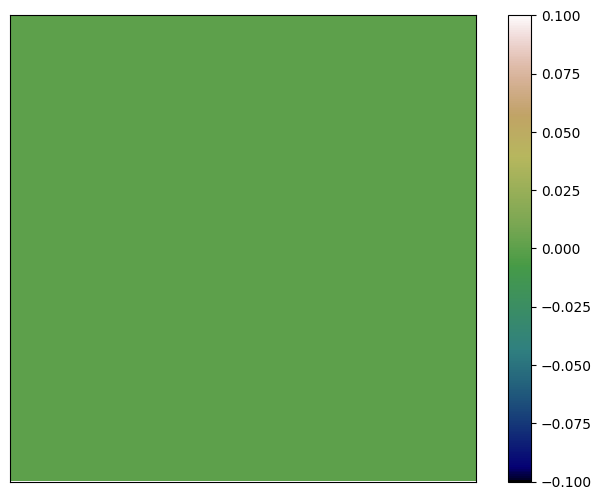

(256, 256) ch-index: 1


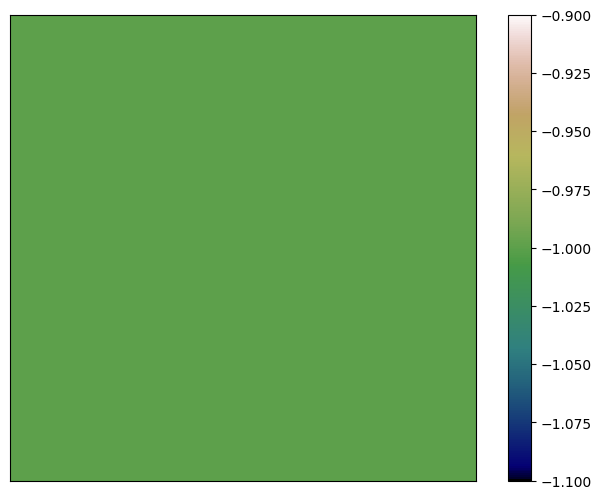

(256, 256) ch-index: 2


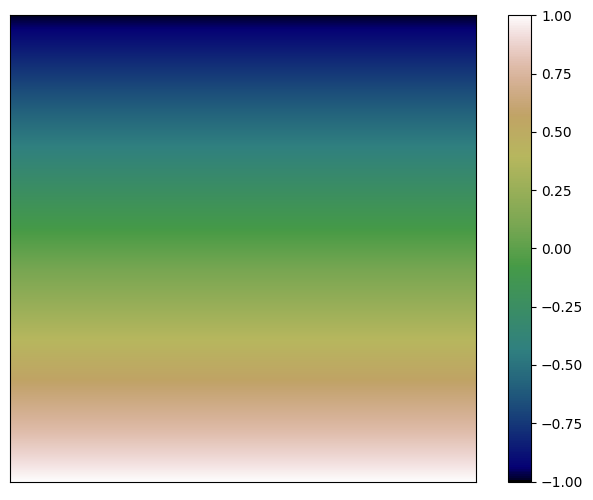

(256, 256) ch-index: 3


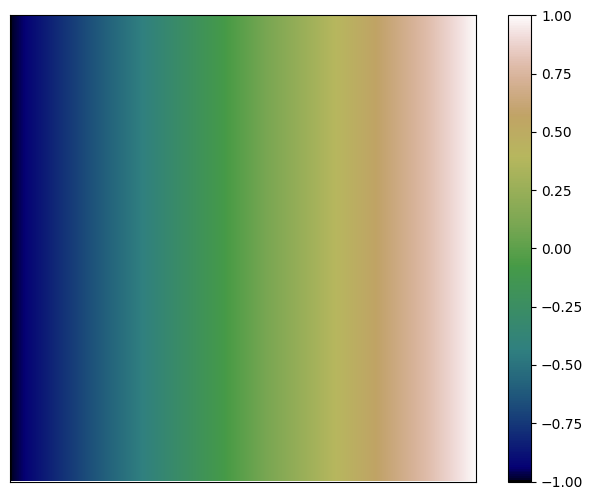

(256, 256) ch-index: 4


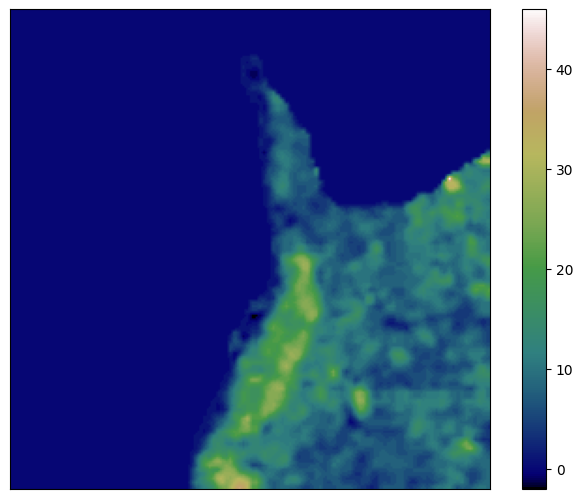

(256, 256) ch-index: 5


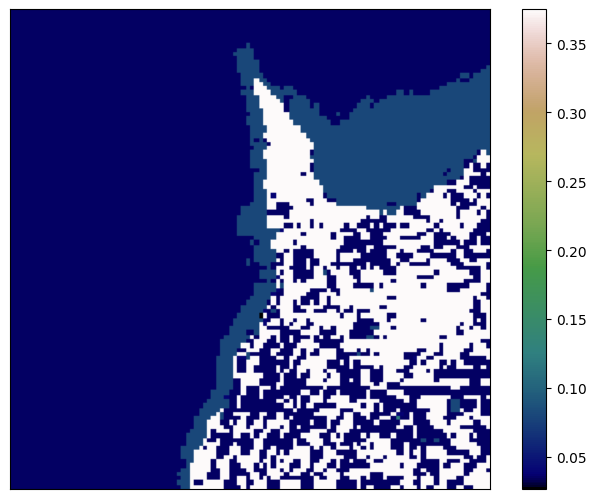

(256, 256) ch-index: 6


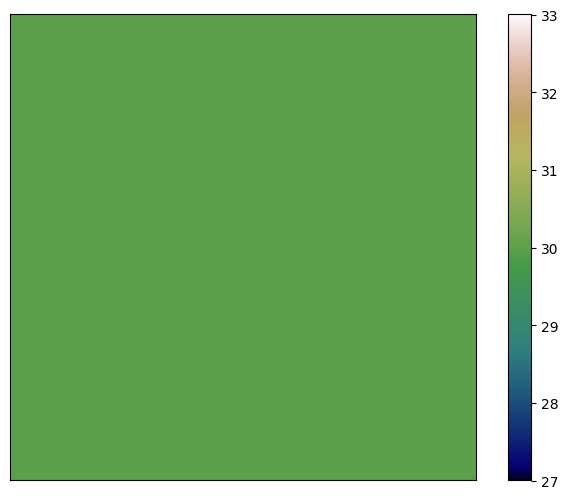

(256, 256) ch-index: 7


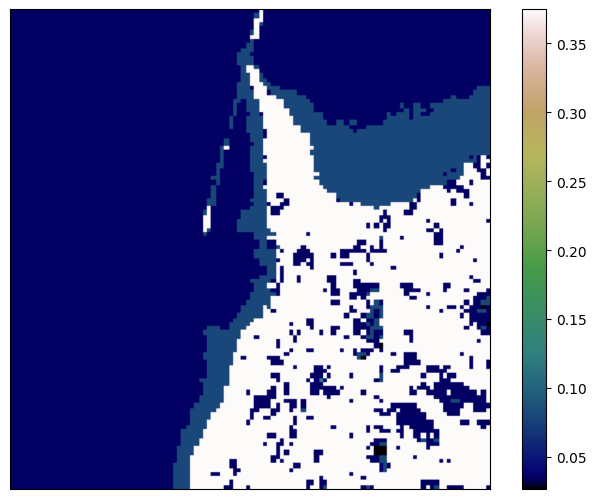

output
(256, 256) ch-index: 0


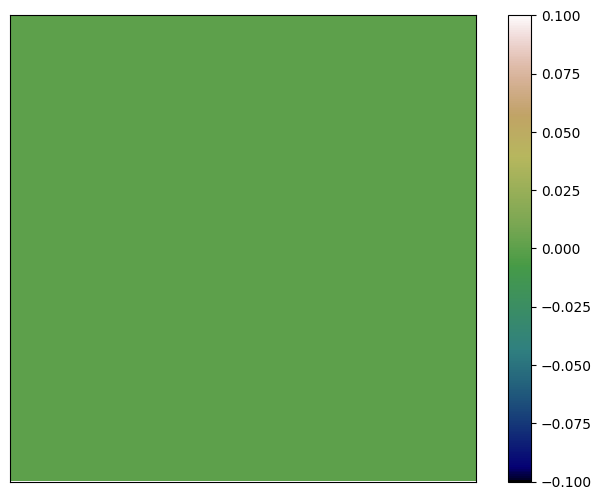

diff is 0.0
(256, 256) ch-index: 1


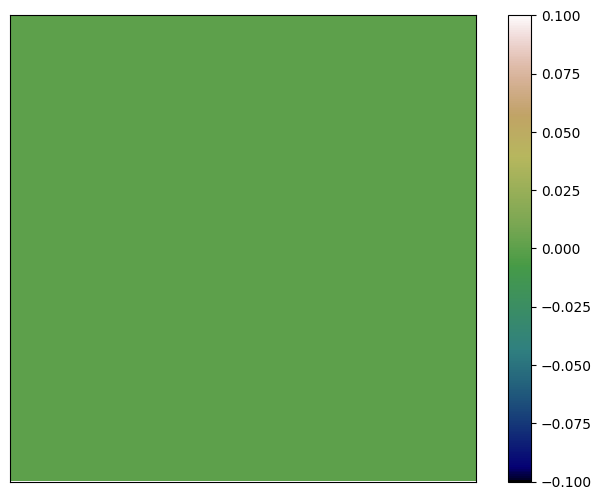

diff is 0.0
(256, 256) ch-index: 2


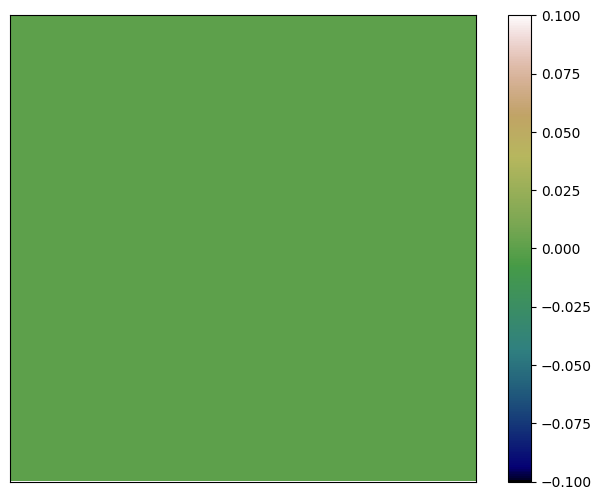

diff is 0.0
(256, 256) ch-index: 3


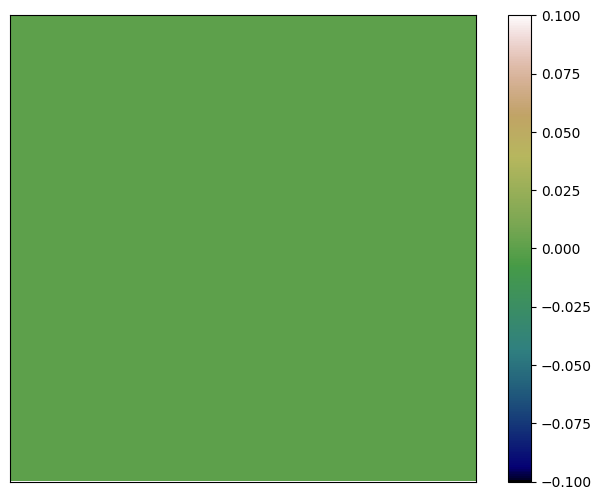

diff is 0.0
(256, 256) ch-index: 4


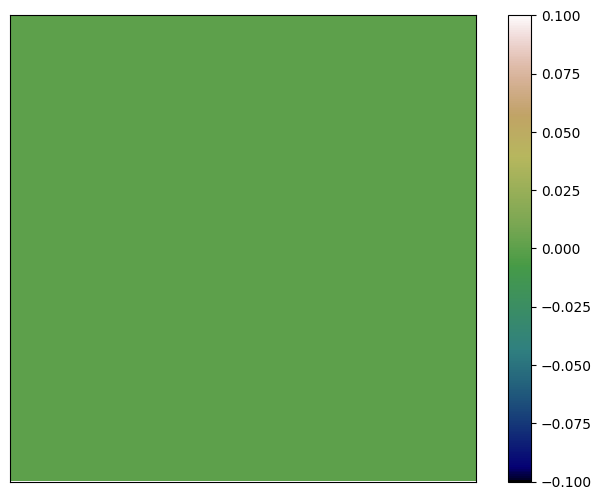

diff is 0.0
(256, 256) ch-index: 5


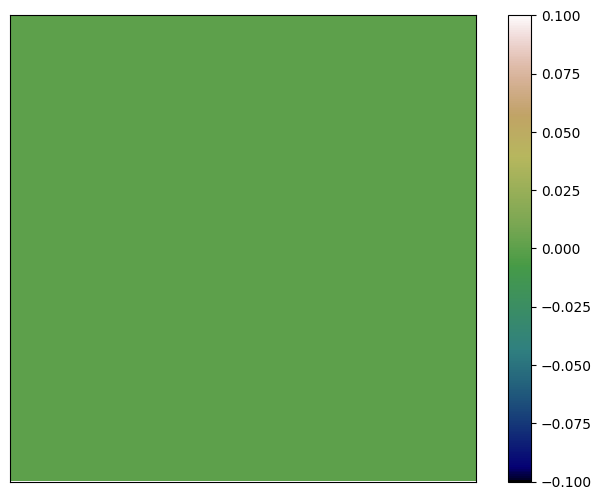

diff is 0.0
(256, 256) ch-index: 6


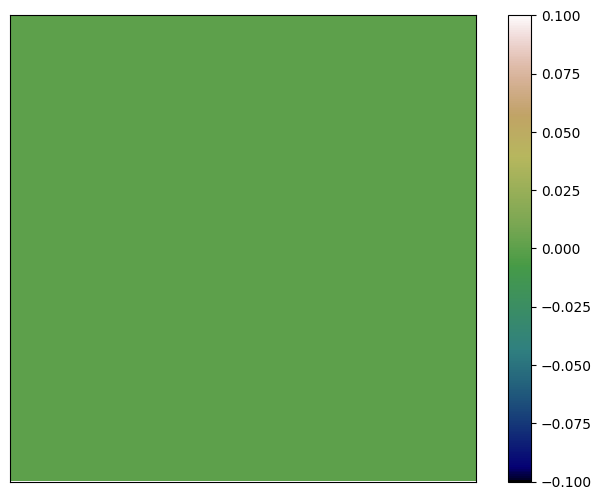

diff is 0.0
(256, 256) ch-index: 7


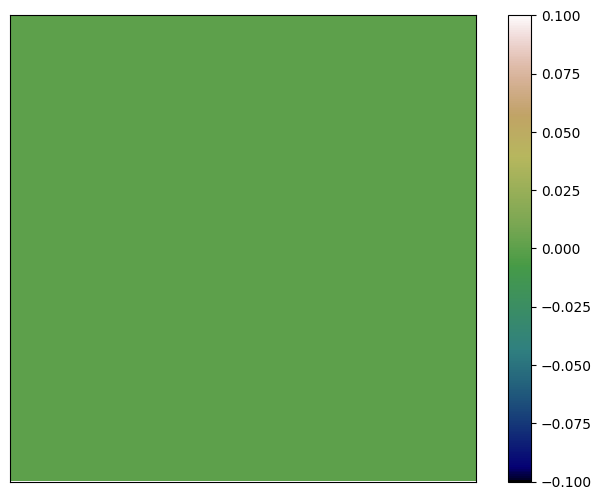

diff is 0.0
(256, 256) ch-index: 8


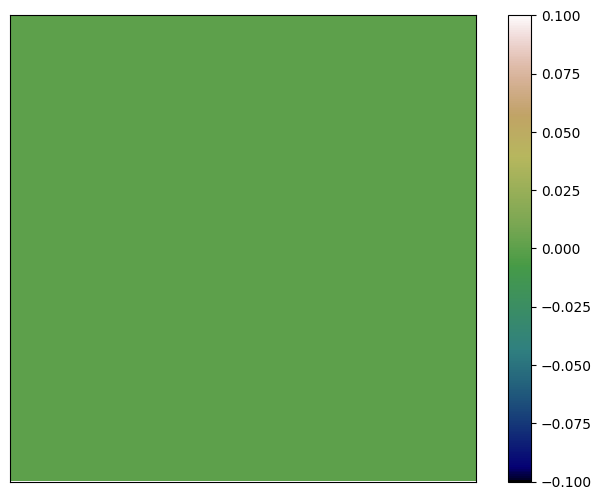

diff is 0.0
(256, 256) ch-index: 9


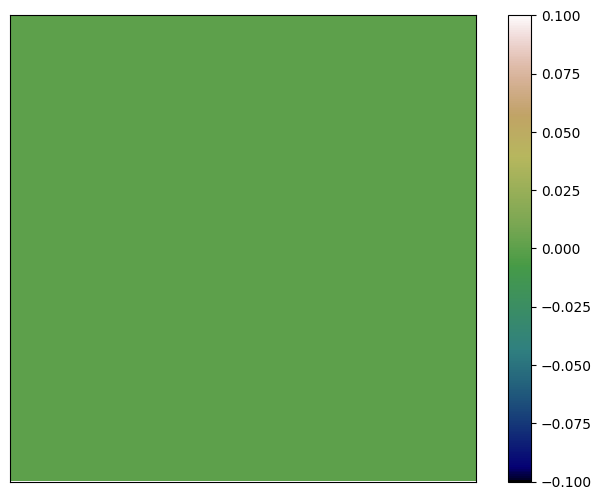

diff is 0.0
(256, 256) ch-index: 10


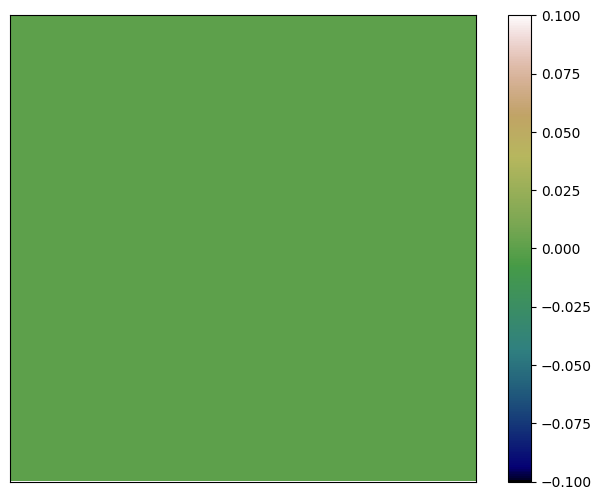

diff is 0.0
(256, 256) ch-index: 11


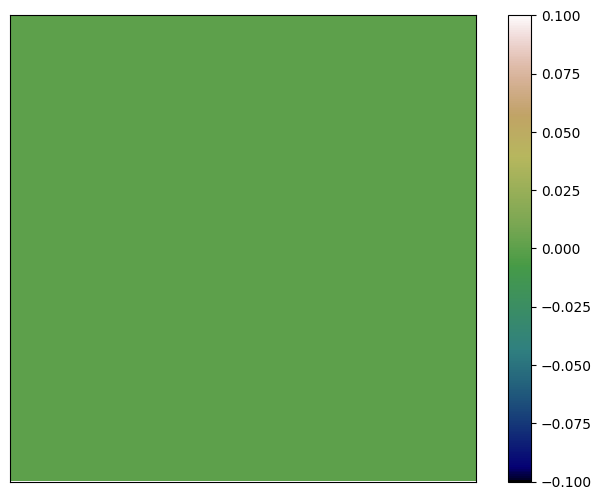

diff is 0.0
(256, 256) ch-index: 12


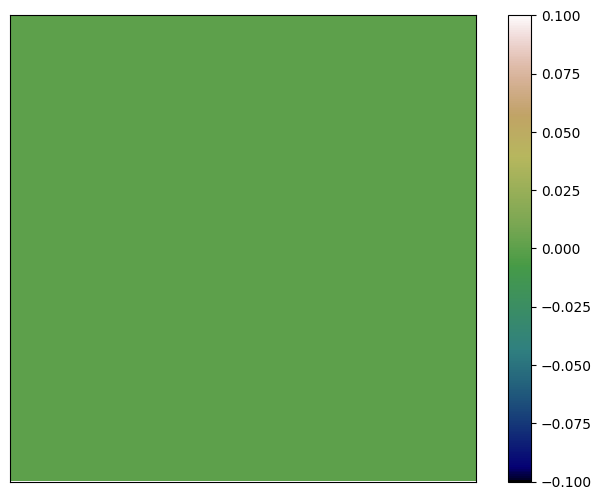

diff is 0.0
(256, 256) ch-index: 13


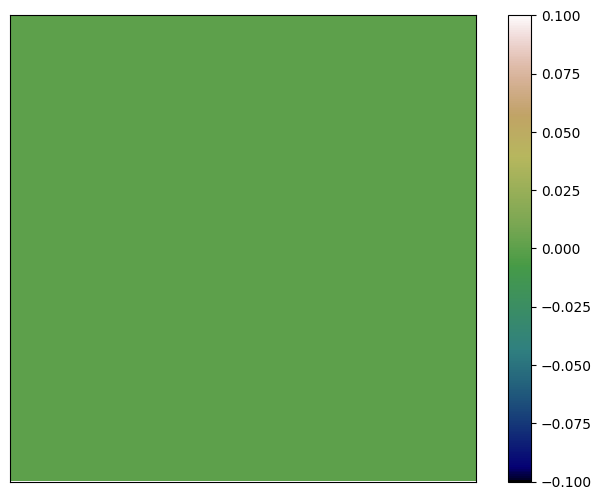

diff is 0.0
(256, 256) ch-index: 14


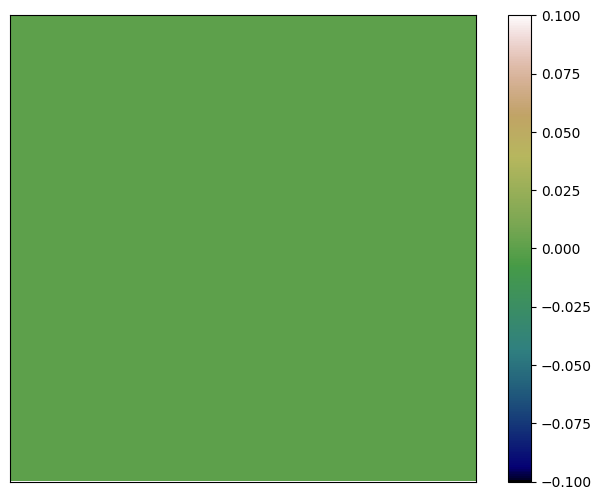

diff is 0.0
(256, 256) ch-index: 15


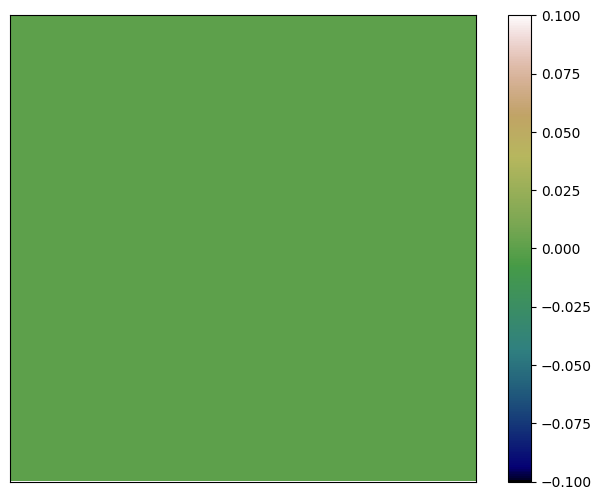

diff is 0.0
(256, 256) ch-index: 16


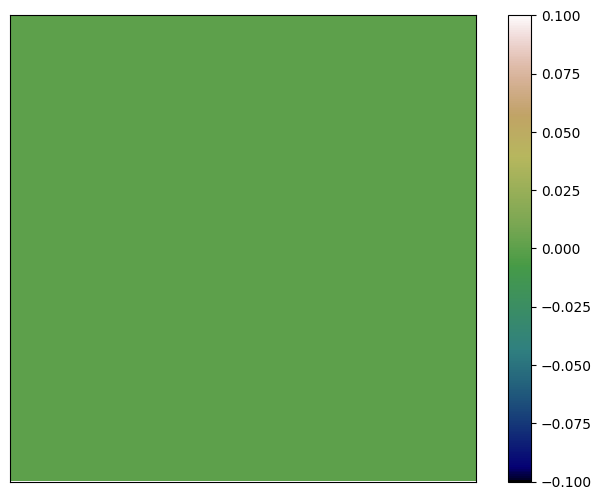

diff is 0.0
(256, 256) ch-index: 17


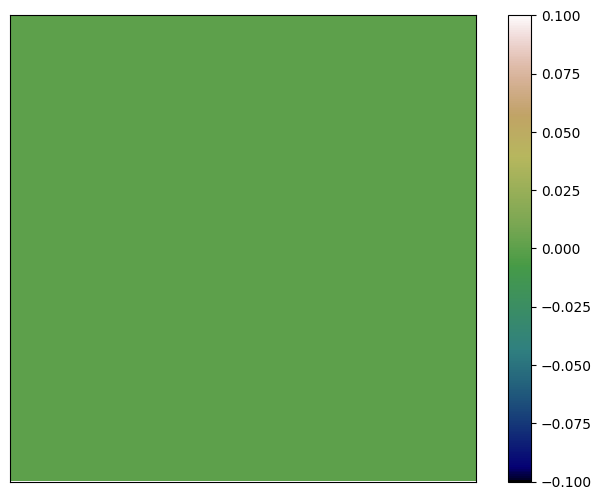

diff is 0.0
(256, 256) ch-index: 18


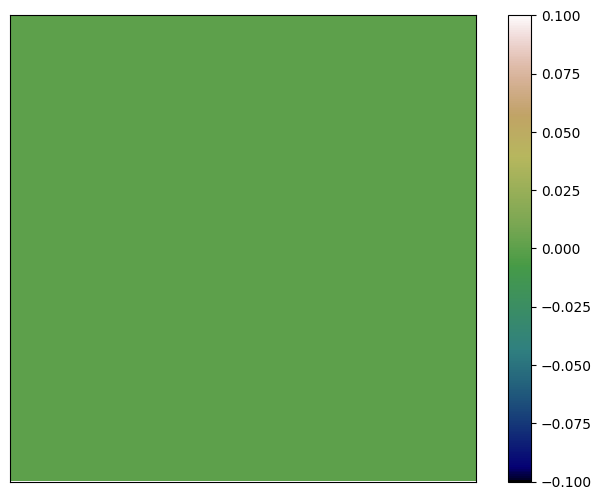

diff is 0.0
(256, 256) ch-index: 19


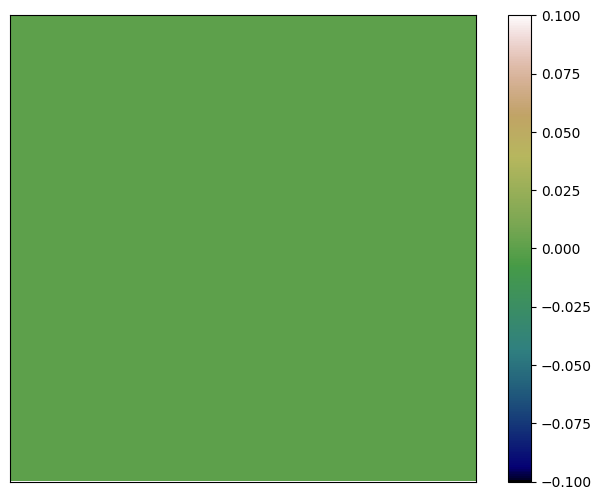

extreme diff is 0.0


In [12]:
x_b, y_b = next(iter(test_loader))
bs = 0
b, h, w, t, cin = x_b.shape
b, _, _, t, cout = y_b.shape
print("input")
for i in range(cin):
  np_array = x_b[bs, :, :, 0, i].cpu().numpy() #* MAX_RAINFALL
  #np_array = x_b[bs, :, :, i, 6].cpu().numpy() #* MAX_RAINFALL
  print(np_array.shape, "ch-index:", i)
  fig = plot_dem(np_array, colorbar=True)   # your helper returns the Figure
  plt.show()

print("output")
for i in range(t):
  np_array = y_b[bs, :, :, i, 0].cpu().numpy() #* MAX_RAINFALL
  if i:
    diff = np.abs(np_array - y_b[bs, :, :, i - 1, 0].cpu().numpy())
    print("diff is", np.max(diff))
  print(np_array.shape, "ch-index:", i)
  fig = plot_dem(np_array, colorbar=True)   # your helper returns the Figure
  plt.show()

diff = np.abs(y_b[bs, :, :, 0, 0].cpu().numpy() - y_b[bs, :, :, t - 1, 0].cpu().numpy())
print("extreme diff is", np.max(diff))
del x_b, y_b

In [13]:
import gc
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi --query-compute-apps=pid --format=csv,noheader | xargs -r -n1 kill -9
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
print(torch.cuda.memory_summary())

kill: (47570): No such process
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |  46080 KiB |  46080 KiB |  46080 KiB |
|       from large pool |      0 B   |  46080 KiB |  46080 KiB |  46080 KiB |
|       from small pool |      0 B   |      0 KiB |      0 KiB |      0 KiB |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |  46080 KiB |  46080 KiB |  46080 KiB |
|       from large pool |      0 

In [ ]:
import rasterio

for fn in ["/content/FloodCastBench/FloodCastBench/Relevant data/DEM/Pakistan_DEM.tif", "/content/FloodCastBench/FloodCastBench/Relevant data/Land use and land cover/Pakistan.tif", "/content/FloodCastBench/FloodCastBench/Relevant data/Rainfall/Pakistan flood/20220823-S000000.tif", '/content/FloodCastBench/FloodCastBench/Low-fidelity flood forecasting/480m/Pakistan/462300.tif']:
    with rasterio.open(fn) as src:
        print(fn,
              src.crs,           # should be EPSG:32642
              src.transform,     # same origin & pixel‐size as DEM
              src.width, src.height)

/content/FloodCastBench/FloodCastBench/Relevant data/DEM/Pakistan_DEM.tif EPSG:32642 | 30.00, 0.00, 337112.92|
| 0.00,-30.00, 3192413.14|
| 0.00, 0.00, 1.00| 7298 13035
/content/FloodCastBench/FloodCastBench/Relevant data/Land use and land cover/Pakistan.tif EPSG:32642 | 30.00, 0.00, 337112.92|
| 0.00,-30.00, 3192413.14|
| 0.00, 0.00, 1.00| 7298 13035
/content/FloodCastBench/FloodCastBench/Relevant data/Rainfall/Pakistan flood/20220823-S000000.tif EPSG:32642 | 30.00, 0.00, 337112.92|
| 0.00,-30.00, 3192413.14|
| 0.00, 0.00, 1.00| 7298 13035
/content/FloodCastBench/FloodCastBench/Low-fidelity flood forecasting/480m/Pakistan/462300.tif None | 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00| 441 810


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [14]:
import torch.nn as nn
import torch


import torch.nn.functional as F


def add_padding(x, num_pad):
    if max(num_pad) > 0:
        res = F.pad(x, (num_pad[0], num_pad[1]), 'constant', 0)
    else:
        res = x
    return res


def add_padding2(x, num_pad1, num_pad2):
    if max(num_pad1) > 0 or max(num_pad2) > 0:
        res = F.pad(x, (num_pad2[0], num_pad2[1], num_pad1[0], num_pad1[1]), 'constant', 0.)
    else:
        res = x
    return res


def remove_padding(x, num_pad):
    if max(num_pad) > 0:
        res = x[..., num_pad[0]:-num_pad[1]]
    else:
        res = x
    return res


def remove_padding2(x, num_pad1, num_pad2):
    if max(num_pad1) > 0 or max(num_pad2) > 0:
        res = x[..., num_pad1[0]:-num_pad1[1], num_pad2[0]:-num_pad2[1]]
    else:
        res = x
    return res


def _get_act(act):
    if act == 'tanh':
        func = F.tanh
    elif act == 'gelu':
        func = F.gelu
    elif act == 'relu':
        func = F.relu_
    elif act == 'elu':
        func = F.elu_
    elif act == 'leaky_relu':
        func = F.leaky_relu_
    else:
        raise ValueError(f'{act} is not supported')
    return func


@torch.jit.script
def compl_mul3d(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    res = torch.einsum("bixyz,ioxyz->boxyz", a, b)
    return res

class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[2,3,4])

        z_dim = min(x_ft.shape[4], self.modes3)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x_ft.shape[2], x_ft.shape[3], self.modes3, device=x.device, dtype=torch.cfloat)

        # if x_ft.shape[4] > self.modes3, truncate; if x_ft.shape[4] < self.modes3, add zero padding
        coeff = torch.zeros(batchsize, self.in_channels, self.modes1, self.modes2, self.modes3, device=x.device, dtype=torch.cfloat)
        coeff[..., :z_dim] = x_ft[:, :, :self.modes1, :self.modes2, :z_dim]
        out_ft[:, :, :self.modes1, :self.modes2, :] = compl_mul3d(coeff, self.weights1)

        coeff = torch.zeros(batchsize, self.in_channels, self.modes1, self.modes2, self.modes3, device=x.device, dtype=torch.cfloat)
        coeff[..., :z_dim] = x_ft[:, :, -self.modes1:, :self.modes2, :z_dim]
        out_ft[:, :, -self.modes1:, :self.modes2, :] = compl_mul3d(coeff, self.weights2)

        coeff = torch.zeros(batchsize, self.in_channels, self.modes1, self.modes2, self.modes3, device=x.device, dtype=torch.cfloat)
        coeff[..., :z_dim] = x_ft[:, :, :self.modes1, -self.modes2:, :z_dim]
        out_ft[:, :, :self.modes1, -self.modes2:, :] = compl_mul3d(coeff, self.weights3)

        coeff = torch.zeros(batchsize, self.in_channels, self.modes1, self.modes2, self.modes3, device=x.device, dtype=torch.cfloat)
        coeff[..., :z_dim] = x_ft[:, :, -self.modes1:, -self.modes2:, :z_dim]
        out_ft[:, :, -self.modes1:, -self.modes2:, :] = compl_mul3d(coeff, self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(2), x.size(3), x.size(4)), dim=[2,3,4])
        return x



class FNN3d(nn.Module):
    def __init__(self,
                 modes1, modes2, modes3,
                 width=16,
                 fc_dim=128,
                 layers=None,
                 in_dim=5, out_dim=3,
                 act='gelu',
                 pad_ratio=[0., 0.]):
        '''
        Args:
            modes1: list of int, first dimension maximal modes for each layer
            modes2: list of int, second dimension maximal modes for each layer
            modes3: list of int, third dimension maximal modes for each layer
            layers: list of int, channels for each layer
            fc_dim: dimension of fully connected layers
            in_dim: int, input dimension
            out_dim: int, output dimension
            act: {tanh, gelu, relu, leaky_relu}, activation function
            pad_ratio: the ratio of the extended domain
        '''
        super(FNN3d, self).__init__()

        if isinstance(pad_ratio, float):
            pad_ratio = [pad_ratio, pad_ratio]
        else:
            assert len(pad_ratio) == 2, 'Cannot add padding in more than 2 directions.'

        self.pad_ratio = pad_ratio
        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.pad_ratio = pad_ratio

        if layers is None:
            self.layers = [width] * 4
        else:
            self.layers = layers
        self.fc0 = nn.Linear(in_dim, layers[0])

        self.sp_convs = nn.ModuleList([SpectralConv3d(
            in_size, out_size, mode1_num, mode2_num, mode3_num)
            for in_size, out_size, mode1_num, mode2_num, mode3_num
            in zip(self.layers, self.layers[1:], self.modes1, self.modes2, self.modes3)])

        self.ws = nn.ModuleList([nn.Conv1d(in_size, out_size, 1)
                                 for in_size, out_size in zip(self.layers, self.layers[1:])])

        self.fc1 = nn.Linear(layers[-1], fc_dim)
        self.fc2 = nn.Linear(fc_dim, out_dim)
        self.act = _get_act(act)

    def forward(self, x):
        '''
        Args:
            x: (batchsize, x_grid, y_grid, t_grid, 3)

        Returns:
            u: (batchsize, x_grid, y_grid, t_grid, 1)

        '''
        size_z = x.shape[-2]
        if max(self.pad_ratio) > 0:
            num_pad = [round(size_z * i) for i in self.pad_ratio]
        else:
            num_pad = [0., 0.]
        length = len(self.ws)
        batchsize = x.shape[0]

        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)
        x = add_padding(x, num_pad=num_pad)
        size_x, size_y, size_z = x.shape[-3], x.shape[-2], x.shape[-1]

        for i, (speconv, w) in enumerate(zip(self.sp_convs, self.ws)):
            x1 = speconv(x)
            x2 = w(x.view(batchsize, self.layers[i], -1)).view(batchsize, self.layers[i+1], size_x, size_y, size_z)
            x = x1 + x2
            if i != length - 1:
                x = self.act(x)
        x = remove_padding(x, num_pad=num_pad)
        x = x.permute(0, 2, 3, 4, 1)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

"""
parser.add_argument('--layers', nargs='+', type=int, default=[16, 24, 24, 32, 32], help='Dimensions/layers of the NN')
parser.add_argument('--modes1', nargs='+', type=int, default=[8, 8, 12, 12], help='')
parser.add_argument('--modes2', nargs='+', type=int, default=[8, 8, 12, 12], help='')
parser.add_argument('--modes3', nargs='+', type=int, default=[8, 8, 8, 8], help='')
parser.add_argument('--fc_dim', type=int, default=128, help='')
parser.add_argument('--epochs', type=int, default=15000)
parser.add_argument('--activation', default='gelu', help='Activation to use in the network.')
"""
layers = [seq_len, 24, 24, 32, 32]
modes1 = [8, 8, 12, 12]
modes2 = [8, 8, 12, 12]
modes3 = [8, 8, 8, 8]
fc_dim = 128
activation = 'gelu'
C_in = 1 + (2 + 1) + 1 + 1 + 1   # depth + (spatial + time) + DEM + Manning + rain step
C_out = 1
#model = PINO2d(modes1=modes1, modes2=modes2, width=fc_dim, layers=layers, in_dim=C_in, out_dim=C_out).to(device)
model = FNN3d(modes1=modes1, modes2=modes2, modes3=modes3, fc_dim=fc_dim, layers=layers, in_dim=C_in, out_dim=C_out).to(device)

In [196]:
len(test_ds)

4

In [33]:
import torch
import torch.nn as nn

# 0. Pick device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 1. Load your trained model
model.load_state_dict(torch.load(f"/content/drive/MyDrive/FLOOD_NET_ML_MODEL/Pakistan-480m-sample/fnn3dplus_australia_v8_33.pth"))
model.to(device).eval()

# 2. Loss (we'll compute MSE manually below)
criterion = nn.MSELoss(reduction="none")

# 3. Initialize accumulators
sum_rmse = 0.0
sum_nse  = 0.0
sum_r    = 0.0
sum_csi_001 = 0.0
sum_csi_01  = 0.0
num_samples = 0

# 4. Loop over your test_loader
for x_batch, y_batch in test_loader:
    # Move data to GPU
    x_full = x_batch.to(device)            # (B, C_in, H, W)
    y_full = y_batch.to(device)            # (B, seq_len=20, H, W)
    B, H, W, T, C = y_full.shape

    #################
    #x_full[:, :, :, :, 6] = 100

    noise = np.random.normal(0, 1, x_full[:, :, :, :, 5].shape)
    #x_full[:, :, :, :, 5] =  torch.from_numpy(noise).to(device)
    #x_full[:, :, :, :, 5] =  0.03 #0.0350 #0.3750
    x_full[:, :, :, :, 0] = 0.0
    #x_full[:, :, :, :, 6] = x_full[:, :, :, :, 6] * 6

    ################

    #############################################
    lulc1 = x_full[:, :, :, :, 5].clone()
    lulc2 = x_full[:, :, :, :, 7].clone()
    x_full = x_full[:, :, :, :, :7]
    #############################################

    # Forward pass
    with torch.no_grad():
        x_full[:, :, :, :, 5] = lulc1
        pred1 = model(x_full)

        x_full[:, :, :, :, 5] = lulc2
        pred2 = model(x_full)
    pred1 = F.threshold(pred1, threshold=0, value=0)
    pred2 = F.threshold(pred2, threshold=0, value=0)



    ##############################

    bs = 0
    b, h, w, t, cin = x_full.shape
    b, _, _, t, cout = y_full.shape
    print("input")
    for i in range(cin):
      np_array = x_full[bs, :, :, 0, i].cpu().numpy() #* MAX_RAINFALL
      print(np_array.shape, "ch-index:", i)
      fig = plot_dem(np_array, colorbar=True)   # your helper returns the Figure
      plt.show()
    """
    print("output")
    for i in range(t):
      np_array = y_full[bs, :, :, i, 0].cpu().numpy() #* MAX_RAINFALL
      if i:
        diff = np.abs(np_array - y_full[bs, :, :, i - 1, 0].cpu().numpy())
        print("diff is", np.max(diff))
      print(np_array.shape, "ch-index:", i)
      fig = plot_dem(np_array, colorbar=True)   # your helper returns the Figure
      plt.show()
    """


    print("model-output")
    flood_max1, flood_max2 = -100, -100
    flood_depth_thresh = 1/10 # in cm
    for i in range(t):
      np_array1 = pred1[bs, :, :, i, 0].cpu().numpy() #* MAX_RAINFALL
      np_array2 = pred2[bs, :, :, i, 0].cpu().numpy()
      print(np_array1.shape, "ch-index:", i)
      print("max diff:", np.abs(np_array1 - np_array2).max())
      flood_extent1, flood_extent2 = (np_array1 >= flood_depth_thresh).sum() / np_array1.size , (np_array2 >= flood_depth_thresh).sum() / np_array2.size
      flood_extent_increase = (flood_extent2 - flood_extent1) / flood_extent1 *100 if flood_extent1 else 0
      flood_max1, flood_max2 = max(flood_max1, np_array1.max()), max(flood_max2, np_array2.max())
      print("flood extent:", flood_extent1, flood_extent2, "flood extennt increase:", flood_extent_increase)
      fig = plot_two_dems(np_array1, np_array2, colorbar=True)
      plt.show()
    print("flood maxes:", flood_max1, flood_max2)

    del x_full, y_full, pred1, pred2

    break


    ##############################

    # Extract only the final forecast step (t=20)
    y_last = y_full
    p_last = pred



    B = p_last.size(0)
    # Flatten spatial dims
    t_flat = y_last.reshape(B, -1)
    p_flat = p_last.reshape(B, -1)

    # RMSE per sample
    mse_per  = ((p_last - y_last)**2).reshape(B, -1).mean(dim=1)
    rmse_per = torch.sqrt(mse_per)

    # NSE per sample
    sse = torch.sum((p_flat - t_flat)**2, dim=1)
    sst = torch.sum((t_flat - t_flat.mean(dim=1, keepdim=True))**2, dim=1)
    nse_per = 1 - sse / sst

    # Pearson r per sample
    t_cent = t_flat - t_flat.mean(dim=1, keepdim=True)
    p_cent = p_flat - p_flat.mean(dim=1, keepdim=True)
    r_per  = torch.sum(t_cent * p_cent, dim=1) / (
                torch.sqrt(torch.sum(t_cent**2, dim=1)) *
                torch.sqrt(torch.sum(p_cent**2, dim=1))
             )

    # CSI per sample at γ=0.001 and γ=0.01
    tp1 = ((p_flat>=0.001)&(t_flat>=0.001)).sum(dim=1).float()
    fp1 = ((p_flat>=0.001)&(t_flat< 0.001)).sum(dim=1).float()
    fn1 = ((p_flat< 0.001)&(t_flat>=0.001)).sum(dim=1).float()
    csi001 = tp1 / (tp1 + fp1 + fn1 + 1e-6)

    tp2 = ((p_flat>=0.01)&(t_flat>=0.01)).sum(dim=1).float()
    fp2 = ((p_flat>=0.01)&(t_flat< 0.01)).sum(dim=1).float()
    fn2 = ((p_flat< 0.01)&(t_flat>=0.01)).sum(dim=1).float()
    csi01  = tp2 / (tp2 + fp2 + fn2 + 1e-6)

    # Accumulate
    sum_rmse     += rmse_per.sum().item()
    sum_nse      += nse_per.sum().item()
    sum_r        += r_per.sum().item()
    sum_csi_001  += csi001.sum().item()
    sum_csi_01   += csi01.sum().item()
    num_samples  += B

# 5. Compute and print averages
avg_rmse    = sum_rmse    / num_samples
avg_nse     = sum_nse     / num_samples
avg_r       = sum_r       / num_samples
avg_csi_001 = sum_csi_001 / num_samples
avg_csi_01  = sum_csi_01  / num_samples

print(f"Batchwise RMSE: {avg_rmse:.6f}")
print(f"Batchwise NSE:  {avg_nse:.6f}")
print(f"Batchwise Pearson r: {avg_r:.6f}")
print(f"Batchwise CSI @0.001m: {avg_csi_001:.6f}")
print(f"Batchwise CSI @0.01m:  {avg_csi_01:.6f}")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
sum([param.numel() for param in model.parameters()])


10230961